# A comparison of text distance algorithms

[![Run nbconvert](https://github.com/micheledinelli/text-distances/actions/workflows/readme.yaml/badge.svg)](https://github.com/micheledinelli/text-distances/actions/workflows/readme.yaml)

In [26]:
import numpy as np
import pandas as pd

import re
from collections import Counter

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

from scipy.stats import wasserstein_distance
from scipy.stats import entropy
from scipy.special import rel_entr

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize

# Download the necessary NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt')

plt.style.use("style.mplstyle")

colors = ["#003f5c", "#d45087", "#ffa600", "#665191", "#ff7c43", "#2f4b7c", "#f95d6a", "#a05195"]

cmap = ListedColormap(sns.color_palette(colors).as_hex())

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/micheledinelli/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/micheledinelli/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/micheledinelli/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Text distance
```
.
└── Text distance
    ├── Length distance
    │   ├── Euclidean distance
    │   ├── Cosine distance
    │   ├── Manhattan distance
    │   └── Hamming distance
    ├── Distribution distance
    │   ├── JS divergence
    │   ├── KL divergence
    │   └── Wasserstein distance
    └── Semantic distance
        ├── Word mover's distance
        └── Word mover's distance extension
```

In [2]:
# import spacy
# import plotly.express as px

# # Load the English language model
# nlp = spacy.load("en_core_web_md")

# # Define the words for which you want vectors
# words = ["man", "woman", "king", "queen"]

# # Get the vectors for each word
# vectors = [nlp(word).vector for word in words]

# # Perform the vector operation (King - Man + Woman)
# result_vector = nlp("king").vector - nlp("man").vector + nlp("woman").vector

# # Combine the word vectors and result vector
# all_vectors = vectors + [result_vector]

# # Use PCA to reduce the dimensionality to 3 for visualization
# pca = PCA(n_components=3)
# vectors_3d = pca.fit_transform(all_vectors)

# # Create a DataFrame for visualization
# import pandas as pd
# df = pd.DataFrame(vectors_3d, columns=['PC1', 'PC2', 'PC3'])
# df['Word'] = words + ['King - Man + Woman']

# # Plot the 3D vectors
# fig = px.scatter_3d(df, x='PC1', y='PC2', z='PC3', text='Word')

# # Update the layout for better visibility
# fig.update_layout(title="Word Vectors Visualization with Result Vector",
#                   scene=dict(xaxis_title='Principal Component 1',
#                              yaxis_title='Principal Component 2',
#                              zaxis_title='Principal Component 3'))

# # Show the plot
# fig.show()


In [3]:
s1 = "Obama speaks to the media in Illinois"
s2 = "The president greets the press in Chicago"
s3 = "Duck"
s4 = "Cool"
s5 = "Rest"

corpus = [s1, s2, s3, s4, s5]

vectorizer = CountVectorizer()
vectorizer.fit(corpus)

matrix = vectorizer.fit_transform(corpus)

table = matrix.todense()
df = pd.DataFrame(table, 
                  columns=vectorizer.get_feature_names_out(), 
                  index=[f"s{i+1}" for i in range(len(corpus))])

df.head()

,chicago,cool,duck,greets,illinois,in,media,obama,president,press,rest,speaks,the,to
s1,0,0,0,0,1,1,1,1,0,0,0,1,1,1
s2,1,0,0,1,0,1,0,0,1,1,0,0,2,0
s3,0,0,1,0,0,0,0,0,0,0,0,0,0,0
s4,0,1,0,0,0,0,0,0,0,0,0,0,0,0
s5,0,0,0,0,0,0,0,0,0,0,1,0,0,0


### Length Distance

#### Algorithms

In [4]:
def euclidean_distance(s1, s2, vectorizer):
    vector1 = vectorizer.transform([s1]).toarray()
    vector2 = vectorizer.transform([s2]).toarray()
    distance = np.linalg.norm(vector1 - vector2)
    return distance

def cosine_distance(s1, s2, vectorizer):
    vector1 = vectorizer.transform([s1]).toarray()
    vector2 = vectorizer.transform([s2]).toarray()
    similarity_matrix = cosine_similarity(vector1, vector2)
    distance = 1 - similarity_matrix[0, 0]
    return distance

def manhattan_distance(s1, s2, vectorizer):
    vector1 = vectorizer.transform([s1]).toarray()
    vector2 = vectorizer.transform([s2]).toarray()
    distance = np.sum(np.abs(vector1 - vector2))
    return distance

def hamming_distance(s1, s2):
    if len(s1) != len(s2):
        raise ValueError("Both strings must be of the same length")
    return sum(ch1 != ch2 for ch1, ch2 in zip(s1, s2))

In [5]:
print(f"Euclidean distance between {s3} and {s4}: {euclidean_distance(s3, s4, vectorizer):.2f}")
print(f"Cosine distance between {s3} and {s4}: {cosine_distance(s3, s4, vectorizer):.2f}")
print(f"Manhattan distance between {s3} and {s4}: {manhattan_distance(s3, s4, vectorizer):.2f}")
print(f"Hamming distance between {s3} and {s4}: {hamming_distance(s3, s4):.2f}")

Euclidean distance between Duck and Cool: 1.41
Cosine distance between Duck and Cool: 1.00
Manhattan distance between Duck and Cool: 2.00
Hamming distance between Duck and Cool: 4.00


In [6]:
def plot_distances(s1: str, s2: str, vectorizer, ax=None):
    if ax:
        # Calculate distances
        euclidean_dist = euclidean_distance(s1, s2, vectorizer)
        cosine_dist = cosine_distance(s1, s2, vectorizer)
        manhattan_dist = manhattan_distance(s1, s2, vectorizer)

        ax.scatter([s1, s2], [0, euclidean_dist], label='Euclidean', color=colors[0])
        ax.scatter([s1, s2], [0, cosine_dist], label='Cosine', color=colors[1])
        ax.scatter([s1, s2], [0, manhattan_dist], label='Manhattan', color=colors[2])

        # Connect the points with lines
        ax.plot([s1, s2], [0, euclidean_dist], linestyle='-', color=colors[0])
        ax.plot([s1, s2], [0, cosine_dist], linestyle='-', color=colors[1])
        ax.plot([s1, s2], [0, manhattan_dist], linestyle='-', color=colors[2])

        # Annotate the distance values
        ax.text(s1, 0, f'{s1}\n(0, 0)', ha='center', va='bottom')
        ax.text(s2, euclidean_dist, f'{s2}\n({euclidean_dist:.2f}, {euclidean_dist:.2f})', ha='center', va='bottom')
        ax.text(s2, cosine_dist, f'{s2}\n({cosine_dist:.2f}, {cosine_dist:.2f})', ha='center', va='bottom')
        ax.text(s2, manhattan_dist, f'{s2}\n({manhattan_dist:.2f}, {manhattan_dist:.2f})', ha='center', va='bottom')
        ax.legend()

        if (len(s1) == len(s2)):
            hamming_dist = hamming_distance(s1, s2)
            ax.scatter([s1, s2], [0, hamming_dist], label='Hamming', color=colors[3])
            ax.plot([s1, s2], [0, hamming_dist], linestyle='-', color=colors[3])
            ax.text(s2, hamming_dist, f'{s2}\n({hamming_dist:.2f}, {hamming_dist:.2f})', ha='center', va='bottom')
        
    else:
        # Calculate distances
        euclidean_dist = euclidean_distance(s1, s2, vectorizer)
        cosine_dist = cosine_distance(s1, s2, vectorizer)
        manhattan_dist = manhattan_distance(s1, s2, vectorizer)

        if len(s1) == len(s2):
            hamming_dist = hamming_distance(s1, s2)
            plt.scatter([s1, s2], [0, hamming_dist], label='Hamming', color=colors[3])
            plt.plot([s1, s2], [0, hamming_dist], linestyle='-', color=colors[3])
            plt.text(s2, hamming_dist, f'{s2}\n({hamming_dist:.2f}, {hamming_dist:.2f})', ha='center', va='bottom')

        # Create a scatter plot
        plt.scatter([s1, s2], [0, euclidean_dist], label='Euclidean', color=colors[0])
        plt.scatter([s1, s2], [0, cosine_dist], label='Cosine', color=colors[1])
        plt.scatter([s1, s2], [0, manhattan_dist], label='Manhattan', color=colors[2])

        # Connect the points with lines
        plt.plot([s1, s2], [0, euclidean_dist], linestyle='-', color=colors[0])
        plt.plot([s1, s2], [0, cosine_dist], linestyle='-', color=colors[1])
        plt.plot([s1, s2], [0, manhattan_dist], linestyle='-', color=colors[2])

        # Annotate the distance values
        plt.text(s1, 0, f'{s1}\n(0, 0)', ha='center', va='bottom')
        plt.text(s2, euclidean_dist, f'{s2}\n({euclidean_dist:.2f}, {euclidean_dist:.2f})', ha='center', va='bottom')
        plt.text(s2, cosine_dist, f'{s2}\n({cosine_dist:.2f}, {cosine_dist:.2f})', ha='center', va='bottom')
        plt.text(s2, manhattan_dist, f'{s2}\n({manhattan_dist:.2f}, {manhattan_dist:.2f})', ha='center', va='bottom')

        # Set labels and title
        plt.xlabel('Sentences')
        plt.ylabel('Distance')
        plt.title('Distances between sentences')
        plt.legend()

        # print(f"Euclidean distance: {euclidean_dist:.2f}, Cosine distance: {cosine_dist:.2f}, Manhattan distance: {manhattan_dist:.2f}, Hamming distance: {hamming_dist}")

        # Show the plot
        plt.figtext(0.5, 0.01, f'Euclidean: {euclidean_dist:.2f}, Cosine: {cosine_dist:.2f}, Manhattan: {manhattan_dist:.2f}', ha='center', va='bottom')
        plt.show()


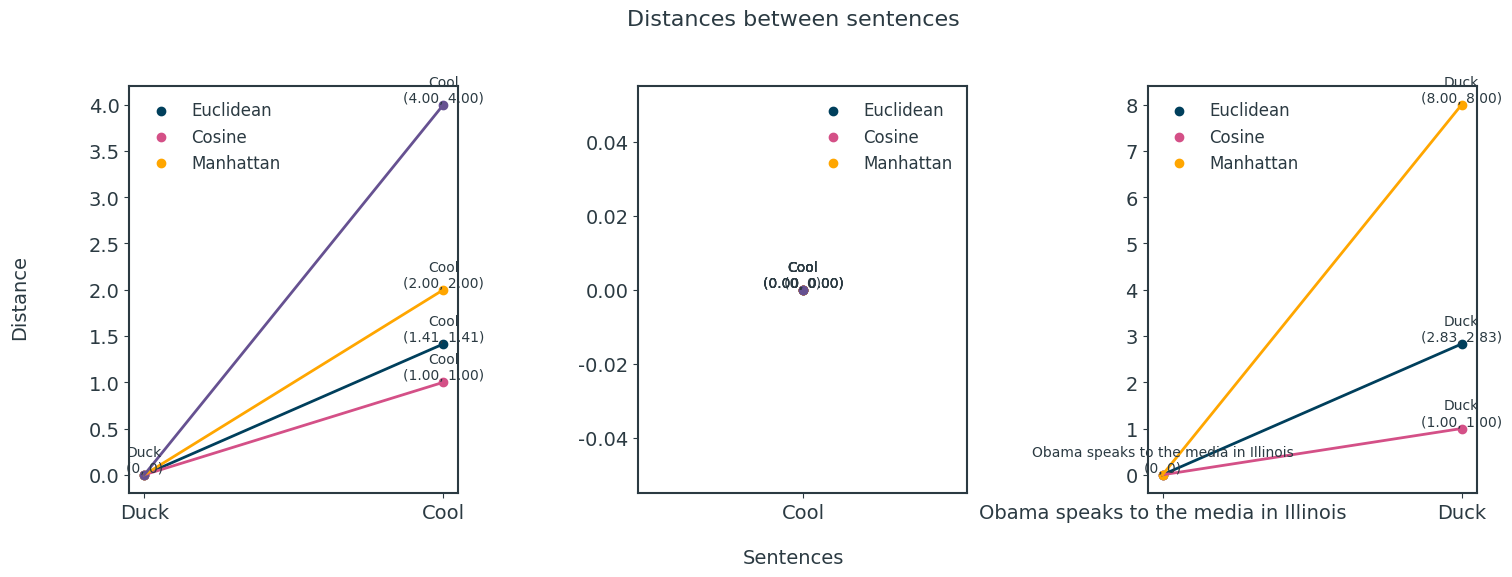

In [7]:
# Create a figure with subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot each pair on the same set of axes
plot_distances(s3, s4, vectorizer, ax=axes[0])
plot_distances(s4, s4, vectorizer, ax=axes[1])
plot_distances(s1, s3, vectorizer, ax=axes[2])

# Set labels and title for the entire figure
fig.suptitle('Distances between sentences', fontsize=16)
fig.text(0.5, 0.05, 'Sentences', ha='center', va='bottom', fontsize=14)
fig.text(0.07, 0.5, 'Distance', ha='center', va='center', rotation='vertical', fontsize=14)

plt.legend()
plt.tight_layout(rect=[0.1, 0.1, 0.9, 0.95])
plt.show()

### Distribution distance

#### Algorithms

In [8]:
def kl_divergence(doc1, doc2):
    # Tokenize documents into words
    words1 = word_tokenize(doc1)
    words2 = word_tokenize(doc2)

    # Compute word frequencies for each document
    freq1 = Counter(words1)
    freq2 = Counter(words2)

    # Combine all unique words from both documents
    all_words = set(freq1.keys()) | set(freq2.keys())

    # Convert frequencies to probabilities
    total1 = len(words1)
    total2 = len(words2)
    prob1 = {word: (freq1[word] + 1) / (total1 + len(all_words)) for word in all_words}
    prob2 = {word: (freq2[word] + 1) / (total2 + len(all_words)) for word in all_words}

    # Compute KL divergence using scipy.stats.entropy
    kl_divergence = entropy(list(prob1.values()), qk=list(prob2.values()))

    return kl_divergence

def js_divergence(doc1, doc2):
    # Tokenize documents into words
    words1 = word_tokenize(doc1)
    words2 = word_tokenize(doc2)

    # Compute word frequencies for each document
    freq1 = Counter(words1)
    freq2 = Counter(words2)

    # Combine all unique words from both documents
    all_words = set(freq1.keys()) | set(freq2.keys())

    # Convert frequencies to probabilities
    total1 = len(words1)
    total2 = len(words2)
    prob1 = {word: (freq1[word] + 1) / (total1 + len(all_words)) for word in all_words}
    prob2 = {word: (freq2[word] + 1) / (total2 + len(all_words)) for word in all_words}

    # Compute average probabilities
    avg_prob = {word: (prob1[word] + prob2[word]) / 2 for word in all_words}

    # Compute JS divergence using KL divergence
    js_divergence = (entropy(list(prob1.values()), qk=list(avg_prob.values())) +
                     entropy(list(prob2.values()), qk=list(avg_prob.values()))) / 2

    return js_divergence

def calculate_wasserstein_distance(doc1, doc2):
    # Tokenize documents into words
    words1 = word_tokenize(doc1)
    words2 = word_tokenize(doc2)

    # Compute word frequencies for each document
    freq1 = Counter(words1)
    freq2 = Counter(words2)

    # Combine all unique words from both documents
    all_words = set(freq1.keys()) | set(freq2.keys())

    # Create distributions for the words in each document
    dist1 = [freq1[word] / len(words1) for word in all_words]
    dist2 = [freq2[word] / len(words2) for word in all_words]

    # Compute Wasserstein distance
    wasserstein_dist = wasserstein_distance(dist1, dist2)

    return wasserstein_dist

def get_distribution(document):
    # Split the document into words, convert to lower case, and count frequencies
    words = re.findall(r'\b\w+\b', document.lower())
    return Counter(words)

# Initialize a Porter stemmer
stemmer = PorterStemmer()

# Define a function to preprocess a document
def preprocess(document):
    # Tokenize the document
    words = word_tokenize(document)

    # Remove stopwords and stem the words
    words = [word for word in words if word not in stopwords.words('english')]

    # Join the words back into a string
    document = ' '.join(words)

    # Return the preprocessed document
    return document

In [9]:
document1 = """
The cat sat on the mat. The cat played with a ball of yarn. It loves the ball and the yarn.
The cat is a happy cat. A really happy cat.
"""
document2 = "Advanced algorithms are key for successful machine learning."

# Preprocess the documents
document1 = preprocess(document1)
document2 = preprocess(document2)

kl_divergence_result = kl_divergence(document1, document2)
js_divergence_result = js_divergence(document1, document2)
wasserstein_distance_result = calculate_wasserstein_distance(document1, document2)

print(f"KL divergence between documents: {kl_divergence_result:.3f}")
print(f"JS divergence between documents: {js_divergence_result:.3f}")
print(f"Wasserstein distance between documents: {wasserstein_distance_result:.3f}") 

KL divergence between documents: 0.303
JS divergence between documents: 0.077
Wasserstein distance between documents: 0.035


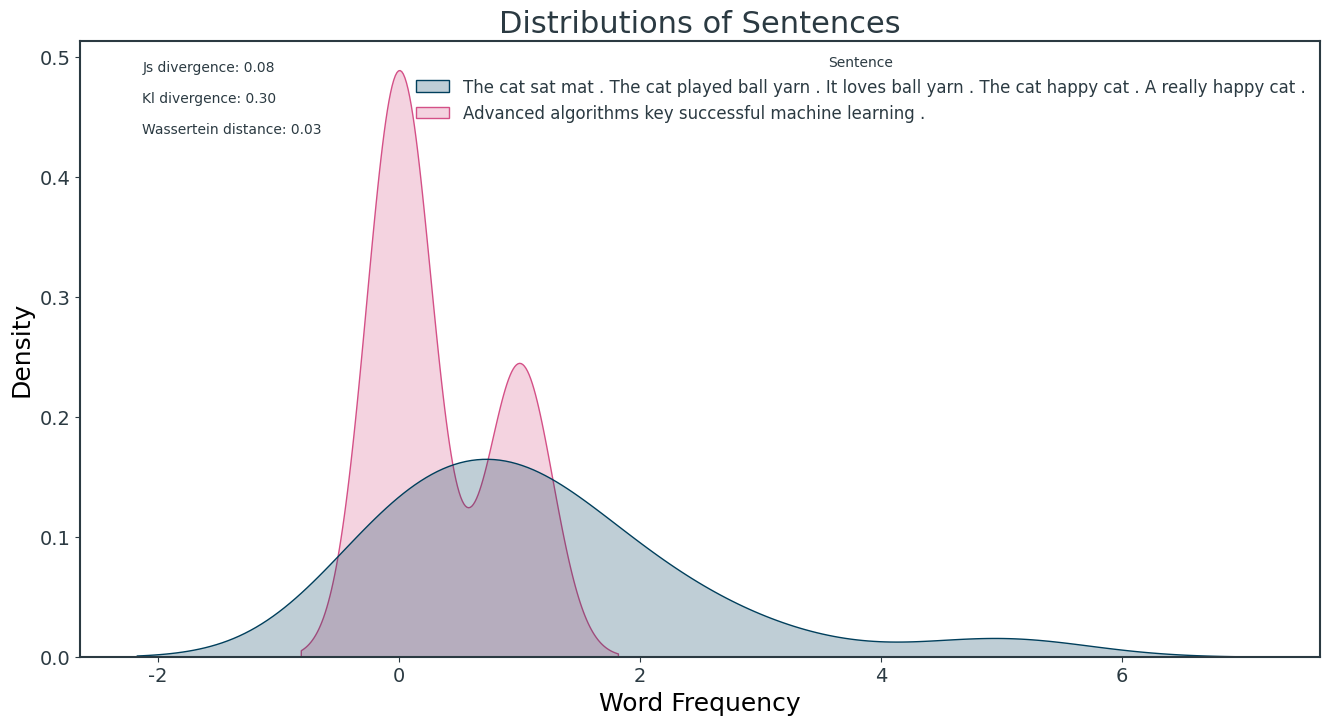

In [10]:
distribution1 = get_distribution(document1)
distribution2 = get_distribution(document2)

# Get all unique words from both distributions
all_words = list(set(distribution1.keys()) | set(distribution2.keys()))

# Create arrays for word frequencies in both distributions
freq1 = np.array([distribution1.get(word, 0) for word in all_words])
freq2 = np.array([distribution2.get(word, 0) for word in all_words])

# Create a DataFrame for Seaborn
df = pd.DataFrame({
    'Words': all_words,
    document1: freq1,
    document2: freq2
})

# Melt the DataFrame to have a format suitable for Seaborn
df_melted = df.melt(id_vars='Words', var_name='Sentence', value_name='Frequency')
# Plot KDE plots for each distribution
plt.figure(figsize=(16, 8))
sns.kdeplot(data=df_melted, x='Frequency', hue='Sentence', fill=True)

kl_divergence_result = kl_divergence(document1, document2)
js_divergence_result = js_divergence(document1, document2)
wasserstein_distance_result = calculate_wasserstein_distance(document1, document2)

plt.annotate(f'Js divergence: {js_divergence_result:.2f}', (0.05, 0.95), xycoords='axes fraction')
plt.annotate(f'Kl divergence: {kl_divergence_result:.2f}', (0.05, 0.90), xycoords='axes fraction')
plt.annotate(f'Wassertein distance: {wasserstein_distance_result:.2f}', (0.05, 0.85), xycoords='axes fraction')

# Set labels and title
plt.xlabel('Word Frequency')
plt.title('Distributions of Sentences')
plt.show()

### Semantic distance

In [11]:
from gensim.models import KeyedVectors

word2vec_path = '/Users/micheledinelli/gensim-data/word2vec-google-news-300/word2vec-google-news-300.gz'
w2v_model = KeyedVectors.load_word2vec_format(word2vec_path, binary=True)

In [35]:
document1 = "the cat sat on the mat."
document2 = "the dog sat on the mat."

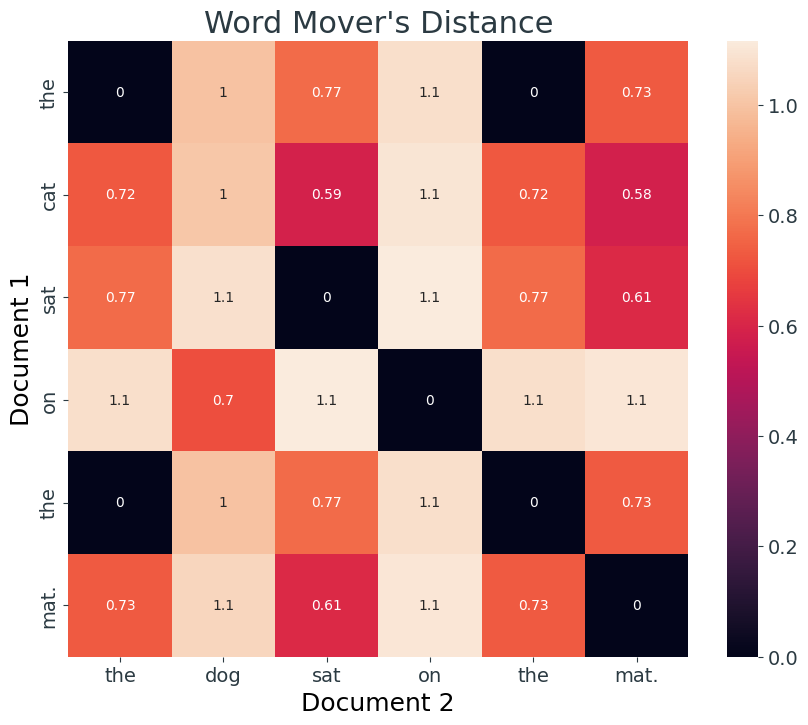

In [36]:
# Create a matrix of word distances
word_distances = np.zeros((len(document1.split()), len(document2.split())))
for i, word1 in enumerate(document1.split()):
    for j, word2 in enumerate(document2.split()):
        word_distances[i, j] = w2v_model.wmdistance(word1, word2)

# Create a heatmap of word distances
plt.figure(figsize=(10, 8))
sns.heatmap(word_distances, annot=True, cmap="rocket", xticklabels=document2.split(), yticklabels=document1.split())
plt.title('Word Mover\'s Distance')
plt.xlabel('Document 2')
plt.ylabel('Document 1')
plt.show()


In [14]:
def visualize_lcs_matrix(X, Y, lcs_matrix, longest_common_subsequence):
    fig, ax = plt.subplots()
    ax.set_title('Longest Common Subsequence Matrix')
    cax = ax.matshow(lcs_matrix, cmap='Blues')

    for i in range(len(X) + 1):
        for j in range(len(Y) + 1):
            ax.text(j, i, str(lcs_matrix[i, j]), ha='center', va='center', color='black')

    ax.set_xticks(np.arange(len(Y) + 1))
    ax.set_yticks(np.arange(len(X) + 1))
    ax.set_xticklabels([''] + list(Y), fontsize=20)
    ax.set_yticklabels([''] + list(X), fontsize=20)
    plt.colorbar(cax)
    fig.text(0.5, 0.05, "Longest Common Subsequence: " + longest_common_subsequence, ha='center', va='bottom', fontsize=14)
    plt.show()

Length of Longest Common Subsequence: 3
Longest Common Subsequence: ool


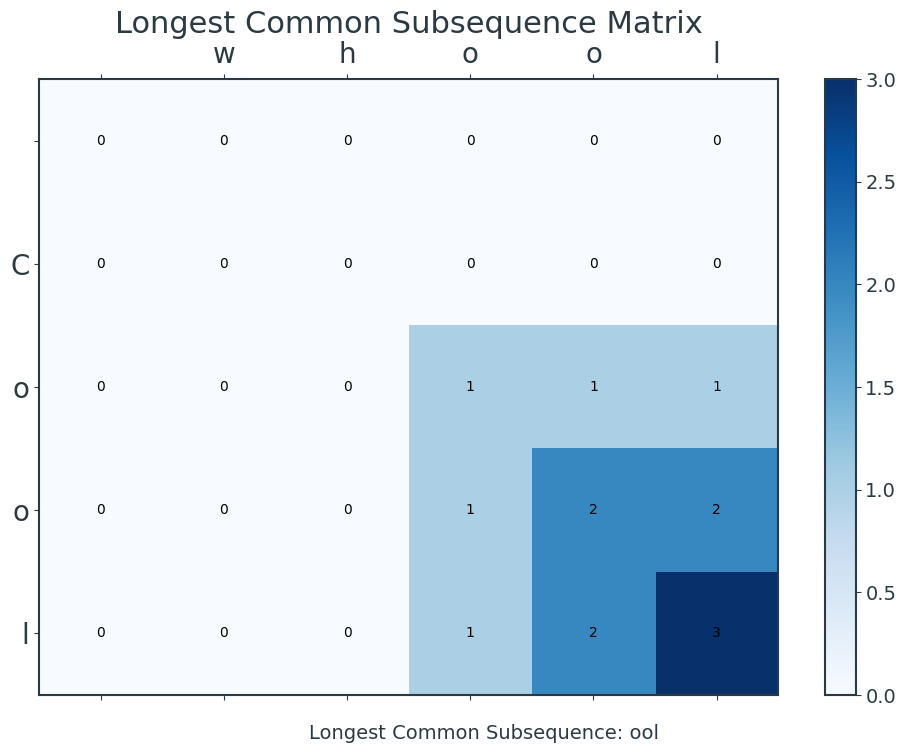

In [15]:
def longest_common_subsequence(X, Y):
    m = len(X)
    n = len(Y)

    # Create a matrix to store lengths of LCS
    lcs_matrix = np.zeros((m+1, n+1), dtype=int)

    # Build the matrix
    for i in range(1, m+1):
        for j in range(1, n+1):
            if X[i-1] == Y[j-1]:
                lcs_matrix[i][j] = lcs_matrix[i-1][j-1] + 1
            else:
                lcs_matrix[i][j] = max(lcs_matrix[i-1][j], lcs_matrix[i][j-1])

    # Find the length of LCS
    length_lcs = lcs_matrix[m][n]

    # Find the actual LCS
    lcs = []
    i, j = m, n
    while i > 0 and j > 0:
        if X[i-1] == Y[j-1]:
            lcs.insert(0, X[i-1])
            i -= 1
            j -= 1
        elif lcs_matrix[i-1][j] > lcs_matrix[i][j-1]:
            i -= 1
        else:
            j -= 1

    return length_lcs, ''.join(lcs), lcs_matrix

length_lcs, lcs_sequence, lcs_matrix = longest_common_subsequence(s4, "whool")
print(f"Length of Longest Common Subsequence: {length_lcs}")
print(f"Longest Common Subsequence: {lcs_sequence}")

visualize_lcs_matrix(s4, "whool", lcs_matrix, lcs_sequence)


## Shallow Windows

- Word2Vec
- BERT

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


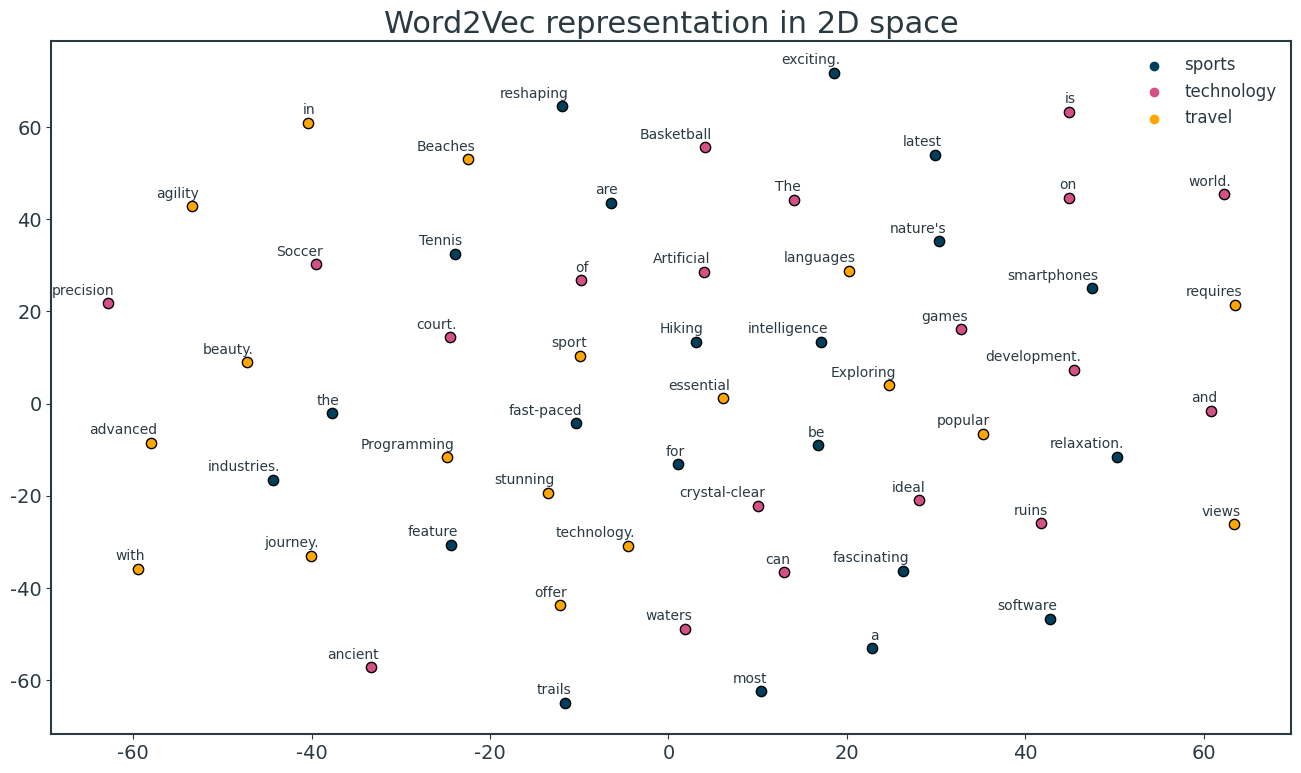

In [19]:
from gensim.models import Word2Vec
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Sample sentences for training
sports_sentences = [
    "Soccer is the most popular sport in the world.",
    "Basketball games are fast-paced and exciting.",
    "Tennis requires precision and agility on the court.",
]

technology_sentences = [
    "Artificial intelligence is reshaping industries.",
    "Programming languages are essential for software development.",
    "The latest smartphones feature advanced technology.",
]

travel_sentences = [
    "Exploring ancient ruins can be a fascinating journey.",
    "Beaches with crystal-clear waters are ideal for relaxation.",
    "Hiking trails offer stunning views of nature's beauty.",
]

# Combine sentences for different groups
all_sentences = sports_sentences + technology_sentences + travel_sentences
labels = ['sports'] * len(sports_sentences) + ['technology'] * len(technology_sentences) + ['travel'] * len(travel_sentences)
colors_map = {'sports': colors[0], 'technology': colors[1], 'travel': colors[2]}

# Tokenize the sentences into words
tokenized_sentences = [sentence.split() for sentence in all_sentences]

# Train Word2Vec model
model = Word2Vec(sentences=tokenized_sentences, vector_size=100, window=5, min_count=1, workers=4)

# Visualize word embeddings using t-SNE
def tsne_plot(model, labels):
    tokens = []
    sentence_colors = []

    for i, word in enumerate(model.wv.index_to_key):
        tokens.append(model.wv[word])
        token_label = labels[i % len(labels)]  # Cycling through labels
        sentence_colors.append(colors_map[token_label])

    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=42)
    new_values = tsne_model.fit_transform(tokens)

    plt.figure(figsize=(16, 9))
    for i in range(len(new_values)):
        plt.scatter(new_values[i, 0], new_values[i, 1], color=sentence_colors[i], ec='black', s=55)
        plt.annotate(model.wv.index_to_key[i], xy=(new_values[i, 0], new_values[i, 1]),
                     xytext=(5, 4), textcoords='offset points', ha='right', va='bottom')

    # Add legends
    for category, color in colors_map.items():
        plt.scatter([], [], color=color, label=category)

    plt.title("Word2Vec representation in 2D space")
    plt.legend()
    plt.show()

# Plot the t-SNE visualization
tsne_plot(model, labels)


In [20]:
from transformers import BertTokenizer, BertModel
import torch

# Load pre-trained BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

bert_corpus = ' '.join(all_sentences)

# Encode a sentence
tokens = tokenizer(bert_corpus, return_tensors='pt')

# Obtain the BERT output
with torch.no_grad():
    outputs = model(**tokens)

# Get the contextualized embeddings for each token
embeddings = outputs.last_hidden_state

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


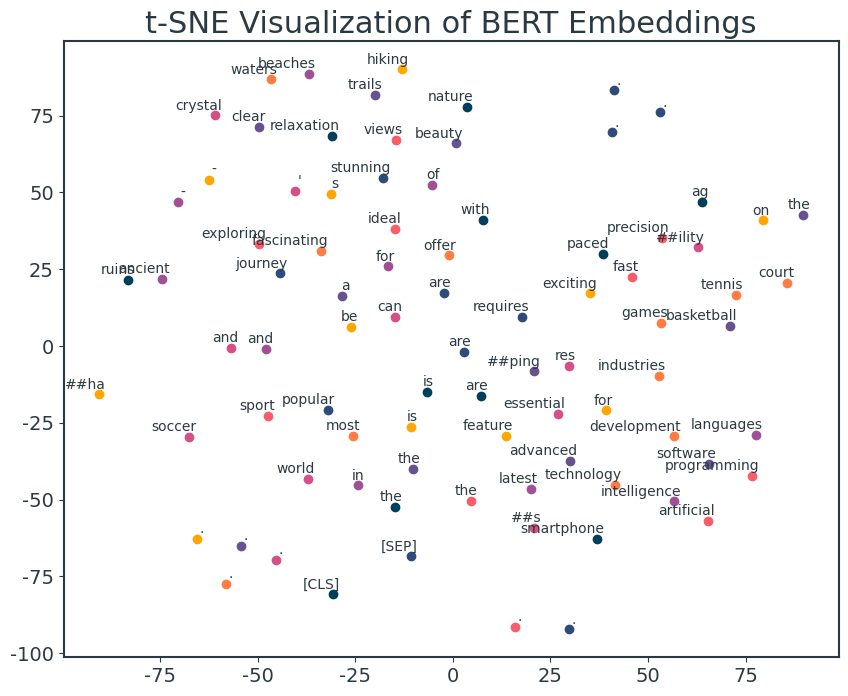

In [21]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Flatten the embeddings for t-SNE
flat_embeddings = embeddings.squeeze().numpy().reshape(-1, embeddings.shape[-1])

# Apply t-SNE for dimensionality reduction
tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(flat_embeddings)

# Plot the 2D embeddings
plt.figure(figsize=(10, 8))
for i, token in enumerate(tokenizer.convert_ids_to_tokens(tokens['input_ids'][0])):
    plt.scatter(embeddings_2d[i, 0], embeddings_2d[i, 1])
    plt.annotate(token, xy=(embeddings_2d[i, 0], embeddings_2d[i, 1]), xytext=(5, 2),
                 textcoords='offset points', ha='right', va='bottom')

plt.title('t-SNE Visualization of BERT Embeddings')
plt.show()


## Matrix factorization methods

In [22]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
import numpy as np
import pprint

# Sample documents
documents = [
    "I love natural language processing with Python",
    "Text similarity and clustering are interesting",
    "Latent Semantic Analysis is a powerful technique",
    "Python is a popular programming language for data science",
]

# Step 1: Create a TF-IDF matrix
vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = vectorizer.fit_transform(documents)

# Display the TF-IDF matrix
print("Corpus:\n")
for doc in documents:
    print(doc)
print("")
print("TF-IDF Matrix:")
pprint.pprint(tfidf_matrix.toarray())
print()

Corpus:

I love natural language processing with Python
Text similarity and clustering are interesting
Latent Semantic Analysis is a powerful technique
Python is a popular programming language for data science

TF-IDF Matrix:
array([[0.        , 0.        , 0.        , 0.        , 0.38274272,
        0.        , 0.48546061, 0.48546061, 0.        , 0.        ,
        0.48546061, 0.        , 0.38274272, 0.        , 0.        ,
        0.        , 0.        , 0.        ],
       [0.        , 0.5       , 0.        , 0.5       , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.5       , 0.        , 0.5       ],
       [0.4472136 , 0.        , 0.        , 0.        , 0.        ,
        0.4472136 , 0.        , 0.        , 0.        , 0.4472136 ,
        0.        , 0.        , 0.        , 0.        , 0.4472136 ,
        0.        , 0.4472136 , 0.        ],
       [0.        , 0.     

In [23]:
# Step 2: Apply SVD to reduce dimensionality
num_topics = 2
svd_model = TruncatedSVD(n_components=num_topics)
lsa_matrix = svd_model.fit_transform(tfidf_matrix)

# Display the SVD components
print("SVD Components:")
print("U Matrix:")
print(svd_model.components_)
print("\nSigma (Singular Values):")
print(svd_model.singular_values_)
print("\nV^T Matrix:")
print(svd_model.transform(tfidf_matrix))
print()

# Display the reduced-dimensional LSA matrix
print("LSA Matrix:")
print(lsa_matrix)
print()

SVD Components:
U Matrix:
[[-2.94802673e-16 -1.29564860e-16  2.74718641e-01 -1.41119974e-16
   4.57355957e-01 -5.71624846e-16  3.05379398e-01  3.05379398e-01
   2.74718641e-01 -5.71624846e-16  3.05379398e-01  2.74718641e-01
   4.57355957e-01  2.74718641e-01 -5.71624846e-16 -1.40286894e-16
  -5.71624846e-16 -1.40286894e-16]
 [ 4.19138354e-01  1.74366856e-01  6.31659656e-16  1.74366856e-01
   2.60518730e-16  4.19138354e-01 -1.60791873e-16 -1.60791873e-16
   4.96734033e-16  4.19138354e-01 -1.60791873e-16  4.96734033e-16
   2.60518730e-16  4.96734033e-16  4.19138354e-01  1.74366856e-01
   4.19138354e-01  1.74366856e-01]]

Sigma (Singular Values):
[1.1240853 1.       ]

V^T Matrix:
[[ 7.94848336e-01 -3.47510668e-17]
 [-2.75629311e-16  3.48733712e-01]
 [-1.15439337e-15  9.37221851e-01]
 [ 7.94848336e-01  1.10605876e-15]]

LSA Matrix:
[[ 7.94848336e-01 -3.47510668e-17]
 [-2.75629311e-16  3.48733712e-01]
 [-1.15439337e-15  9.37221851e-01]
 [ 7.94848336e-01  1.10605876e-15]]



In [24]:
# Step 3: Calculate cosine similarity between documents in the reduced space
from sklearn.metrics.pairwise import cosine_similarity
similarity_matrix = cosine_similarity(lsa_matrix, lsa_matrix)

# Display the cosine similarity matrix
print("Cosine Similarity Matrix:")
print(similarity_matrix)

Cosine Similarity Matrix:
[[ 1.00000000e+00 -8.34092230e-16 -1.27543875e-15  1.00000000e+00]
 [-8.34092230e-16  1.00000000e+00  1.00000000e+00  6.01162497e-16]
 [-1.27543875e-15  1.00000000e+00  1.00000000e+00  1.59815980e-16]
 [ 1.00000000e+00  6.01162497e-16  1.59815980e-16  1.00000000e+00]]


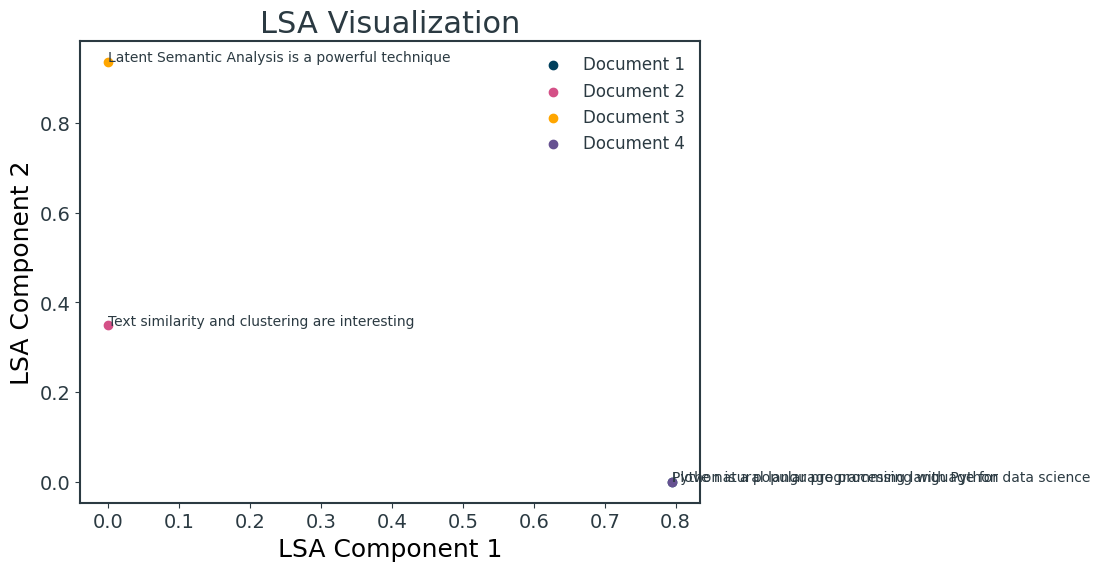

In [25]:
import matplotlib.pyplot as plt

# Visualize the documents in the reduced space
plt.figure(figsize=(8, 6))
for i in range(len(documents)):
    plt.scatter(lsa_matrix[i, 0], lsa_matrix[i, 1], label=f"Document {i + 1}")

plt.title("LSA Visualization")
plt.xlabel("LSA Component 1")
plt.ylabel("LSA Component 2")

# Annotate points with document labels
for i, txt in enumerate(documents):
    plt.annotate(txt, (lsa_matrix[i, 0], lsa_matrix[i, 1]))

plt.legend()
plt.show()      
